In [195]:
from library.algorithms.genetic_algorithms.crossover import partial_crossover
from library.algorithms.genetic_algorithms import crossover
from library.algorithms.genetic_algorithms import mutation, selection, algorithm,crossover
from musical_festival_lineup.mf_lineup_data import MFLineupData
from musical_festival_lineup.mf_lineup_solver import *
from library.algorithms.genetic_algorithms.selection import *
from library.algorithms.genetic_algorithms.crossover import *
from library.algorithms.genetic_algorithms.mutation import *
from musical_festival_lineup.mf_lineup import MFLineupSolution
from musical_festival_lineup.mf_lineup_SA import MFLineupSASolution
from musical_festival_lineup.mf_lineup_HA import MFLineupHCSolution
from musical_festival_lineup.utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from scipy.stats import wilcoxon
import textwrap

In [4]:
warnings.simplefilter("ignore", category=FutureWarning)

### 1. Overall performance of each algorithm


In [139]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this initial experiment, we’ll evaluate the overall performance of the following algorithms:
- **Hill Climbing** (HC) using a consecutive city swap neighborhood.
- **Simulated Annealing** (SA) with the same neighborhood and the following hyperparameters:
    - C = 100
    - L = 1
    - H = 1.1
    - Maximum iterations: 1000
- **Genetic Algorithm (GA)** with:
    - Swap mutation (probability: 0.8)
    - Partial crossover (probability: 0.9)
    - Population size: 50
    - Generations: 20
    - Elitism: enabled <br>

At this stage, the hyperparameters are not tuned for optimal performance — the goal is to get a general sense of how each algorithm performs.
To ensure a fair comparison, we’ve aligned the total number of evaluations:
SA and GA both use a population size of 50 and 20 generations, resulting in 1000 evaluations, matching the 1000 iterations used for HC.
We’ll perform hyperparameter tuning later for the most promising algorithms and compare their optimized versions at the end.

- Creating an instance of data

In [95]:
data=MFLineupData()

In [96]:
overall_results=[]
for i in range(30):
    best_HC=run_HC(data)
    best_SA,_=run_SA(data=data,neighbor_function=swap_mutation,C=100, L=1, H=1.2,max_iter=1000)
    best_GA,_=run_GA(data,
                    pop_size=50,
                    max_gen=20,
                    selection_algorithm=lambda population, maximization: 
                                             tournament_selection(
                                                population=population,
                                                tournament_size=7,
                                                maximization=True
                                            ),
                    crossover_function=partial_crossover,
                    mutation_function=swap_mutation
                    )
    overall_results.append({"run_id":i, "model":"HC", "fitness":best_HC.fitness()})
    overall_results.append({"run_id":i, "model":"SA", "fitness":best_SA.fitness()})
    overall_results.append({"run_id":i, "model":"GA", "fitness":best_GA.fitness()})
overall_results_df=pd.DataFrame(overall_results)
overall_results_df.to_csv("overall_results.csv")

In [97]:
overall_results_df.head()

,run_id,model,fitness
0,0,HC,1.015397
1,0,SA,1.654716
2,0,GA,1.563718
3,1,HC,1.041359
4,1,SA,1.657431


- Lets see the boxblots

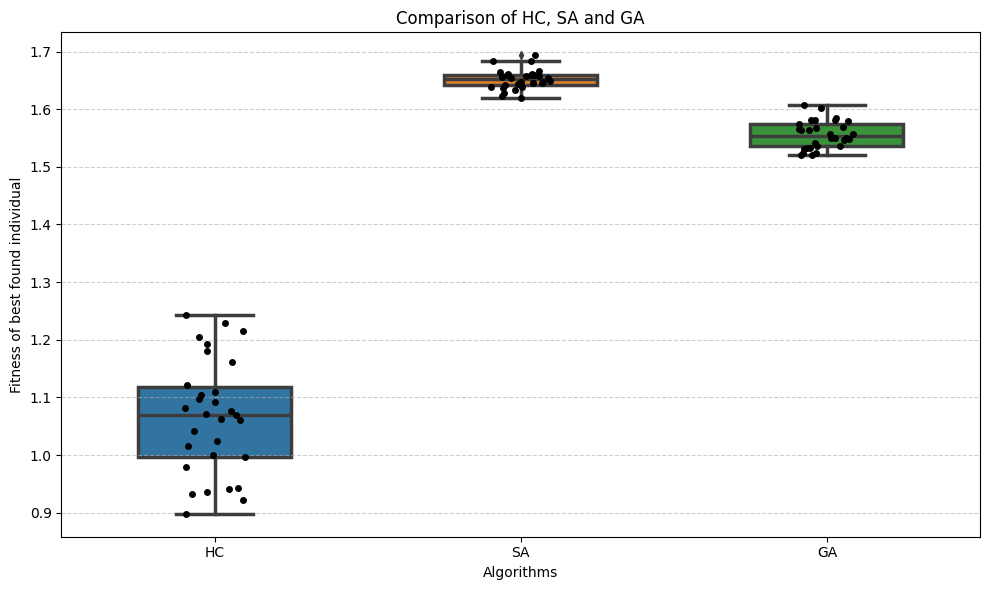

In [98]:
# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='model', y='fitness', data=overall_results_df, width=0.5, linewidth=2.5, fliersize=4)
sns.stripplot(x='model', y='fitness', data=overall_results_df, 
              color='black', size=5, jitter=True, ax=ax)
# Titles and labels
plt.title('Comparison of HC, SA and GA')
plt.xlabel('Algorithms')
plt.ylabel('Fitness of best found individual')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

- **Hill Climbing (HC)** behaves as expected, searching for a local optimum. As a result, the final solution is highly dependent on the initial starting point. This is evident in the boxplot, where the results are widely spread. Due to its inconsistency, we’ll exclude HC from future experiments.

-  **Simulated Annealing (SA)**- outperforms all other algorithms, including the Genetic Algorithm. Its results are tightly clustered, indicating strong consistency and low variability. Given this solid performance, we’ll continue working with SA and focus on optimising its hyperparameters.

- **Genetic Algorithm (GA)** isn’t surpassing SA at this stage, but it’s producing consistent results with relatively low variability. We’ll include GA in the next round of experiments and aim to improve its performance through careful hyperparameter tuning.

It’s important to note that GA has not been fine-tuned yet. In the next phase, we’ll tune both SA and GA, and then compare their optimised versions to determine the final winner.

### 2. Simulated Annealing (SA):  Fine-tuning of hyperparameters

In [100]:
param_grid = {
    "neighbor_function": [
        swap_mutation,
        insert_mutation     
    ],
    "C": [ 200,100]      
    ,
    "L": [1,10,20],
    "H":[1.01,1.1],
}

fixed_params = {
    "max_iter": 1000,
    "data": data
} 

In [103]:

sa_df_results = run_algorithms_grid_search(
    algorithm_func=run_SA,
    param_grid=param_grid,
    fixed_params=fixed_params,
    runs_per_config=30,
    output_csv_path="sa_grid_results.csv"
)

Running config: neighbor_function=swap_mutation__C=200__L=1__H=1.01
Running config: neighbor_function=swap_mutation__C=200__L=1__H=1.1
Running config: neighbor_function=swap_mutation__C=200__L=10__H=1.01
Running config: neighbor_function=swap_mutation__C=200__L=10__H=1.1
Running config: neighbor_function=swap_mutation__C=200__L=20__H=1.01
Running config: neighbor_function=swap_mutation__C=200__L=20__H=1.1
Running config: neighbor_function=swap_mutation__C=100__L=1__H=1.01
Running config: neighbor_function=swap_mutation__C=100__L=1__H=1.1
Running config: neighbor_function=swap_mutation__C=100__L=10__H=1.01
Running config: neighbor_function=swap_mutation__C=100__L=10__H=1.1
Running config: neighbor_function=swap_mutation__C=100__L=20__H=1.01
Running config: neighbor_function=swap_mutation__C=100__L=20__H=1.1
Running config: neighbor_function=insert_mutation__C=200__L=1__H=1.01
Running config: neighbor_function=insert_mutation__C=200__L=1__H=1.1
Running config: neighbor_function=insert_mu

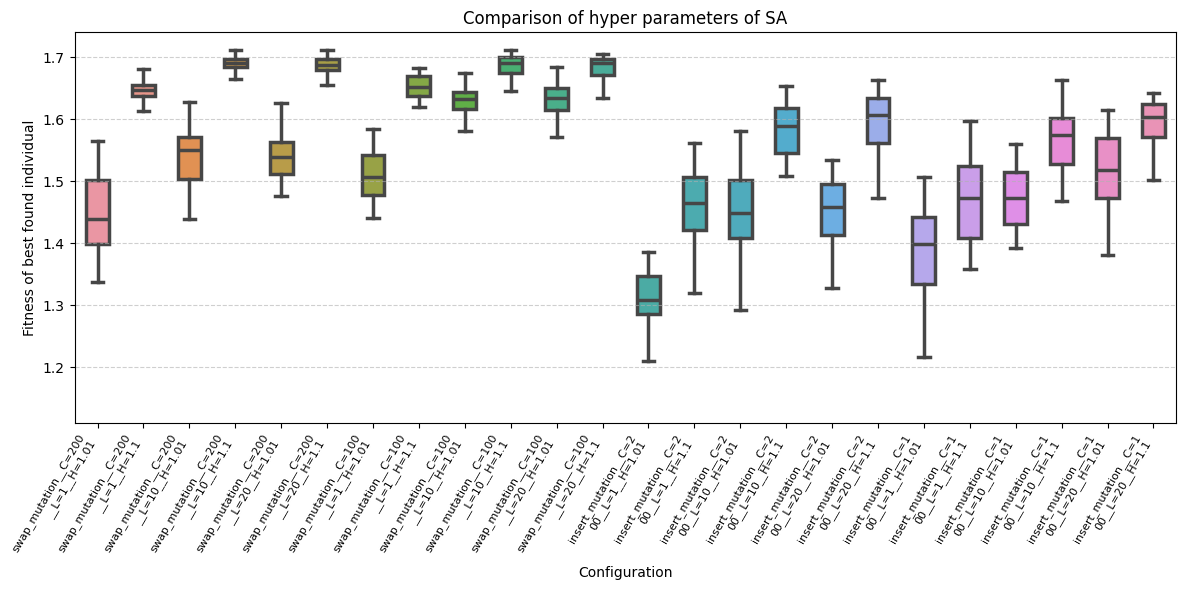

In [124]:
plt.figure(figsize=(12, 6))

# Create boxplot
ax = sns.boxplot(x='config_label', y='best_fitness', data=sa_df_results, 
                 width=0.5, linewidth=2.5, fliersize=0)

plt.title('Comparison of hyper parameters of SA')
plt.xlabel('Configuration')
plt.ylabel('Fitness of best found individual')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

# Replace 'neighbor_function', wrap, and rotate labels with smaller font
labels = [
    textwrap.fill(label.get_text().replace('neighbor_function=', ''), 20)
    for label in ax.get_xticklabels()
]
ax.set_xticklabels(labels, rotation=60, ha='right', fontsize=8)  # Adjust fontsize here

plt.tight_layout()
plt.show()

- The swap mutation consistently produced better fitness values compared to the insert mutation. Among the tested configurations, those with C=200, combined with L=20 or L=10 and H=1.1, achieved the highest fitness of the best-found individuals.
Given these results, we will select this configuration for further comparison against the genetic algorithm in the next stage of our study.

### 3. Genetic Algorithm: Implementation and fine-tuning of hyperparameters


In [210]:
def tournament_selection_3(popupulation, maximization):
    return tournament_selection(
          population=popupulation,
          tournament_size=3,
          maximization=True
     )

def tournament_selection_5(popupulation, maximization):
    return tournament_selection(
          population=popupulation,
          tournament_size=5,
          maximization=True
     )

def tournament_selection_7(popupulation, maximization):
    return tournament_selection(
          population=popupulation,
          tournament_size=7,
          maximization=True
     )


#### 3.1. 6	Genetic Algorithm: Implementation and fine-tuning of hyperparameters

- Lets try the same configuration increasing the population size=100 and and the number of generations 200 and try to see the impact of selection algorithm and elitism across generations

In [200]:
param_grid = {
    "elitism":[True,False],
    "selection_algorithm":[tournament_selection_3, tournament_selection_5, tournament_selection_7, fitness_proportionate_selection,ranking_selection]
}

fixed_params = {
    "pop_size": 100,
    "max_gen": 200,
    "data": data,
    "crossover_function": partial_crossover,
    "xo_prob": 0.8,
    "mutation_function": swap_mutation,
    "mut_prob": 0.8
} 

In [201]:
elitism_selection_df = run_algorithms_grid_search(
    algorithm_func=run_GA,
    param_grid=param_grid,
    fixed_params=fixed_params,
    runs_per_config=30,
    output_csv_path="ga_grid_selection_elitism_results.csv",
)

Running config: elitism=True__selection_algorithm=tournament_selection_3
Running config: elitism=True__selection_algorithm=tournament_selection_5
Running config: elitism=True__selection_algorithm=tournament_selection_7
Running config: elitism=True__selection_algorithm=fitness_proportionate_selection
Running config: elitism=True__selection_algorithm=ranking_selection
Running config: elitism=False__selection_algorithm=tournament_selection_3
Running config: elitism=False__selection_algorithm=tournament_selection_5
Running config: elitism=False__selection_algorithm=tournament_selection_7
Running config: elitism=False__selection_algorithm=fitness_proportionate_selection
Running config: elitism=False__selection_algorithm=ranking_selection
Saved results to ga_grid_selection_elitism_results.csv


- We now have the results organised by run and generation. This allows us to observe either the mean or the median (which is more robust to outliers) fitness of the best individual for each run at every generation




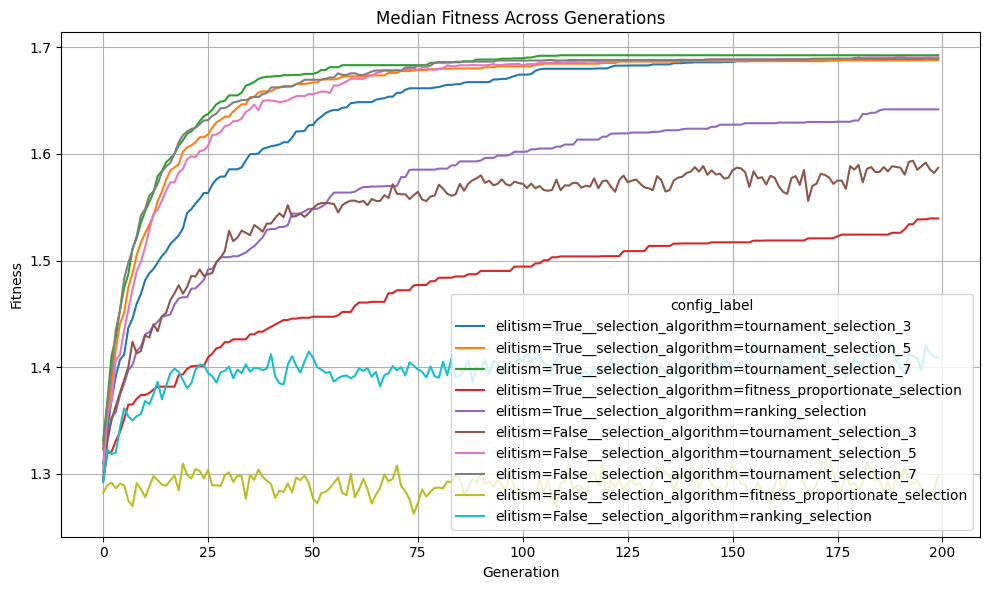

In [204]:
plot_median_fitness_over_gen(elitism_selection_df)


- without mut_prob =0.8

Running config: elitism=True__selection_algorithm=tournament_selection_3
Running config: elitism=True__selection_algorithm=tournament_selection_5
Running config: elitism=True__selection_algorithm=tournament_selection_7
Running config: elitism=True__selection_algorithm=fitness_proportionate_selection
Running config: elitism=True__selection_algorithm=ranking_selection
Running config: elitism=False__selection_algorithm=tournament_selection_3
Running config: elitism=False__selection_algorithm=tournament_selection_5
Running config: elitism=False__selection_algorithm=tournament_selection_7
Running config: elitism=False__selection_algorithm=fitness_proportionate_selection
Running config: elitism=False__selection_algorithm=ranking_selection
Saved results to ga_grid_tounament_results.csv


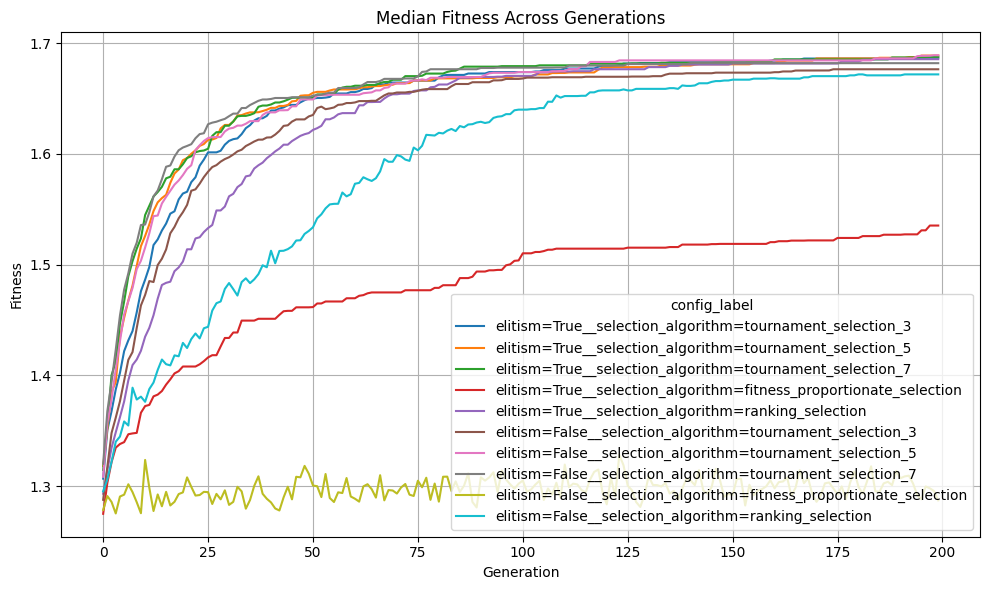

In [214]:
param_grid = {
    "elitism":[True,False],
    "selection_algorithm":[tournament_selection_3, tournament_selection_5, tournament_selection_7, fitness_proportionate_selection,ranking_selection]
}

fixed_params = {
    "pop_size": 100,
    "max_gen": 200,
    "data": data,
    "crossover_function": partial_crossover,
    "xo_prob": 0.8,
    "mutation_function": swap_mutation,
   
} 
tounament_without_mut_selection_df = run_algorithms_grid_search(
    algorithm_func=run_GA,
    param_grid=param_grid,
    fixed_params=fixed_params,
    runs_per_config=30,
    output_csv_path="ga_grid_tounament_results.csv",
)
plot_median_fitness_over_gen(tounament_without_mut_selection_df)

#### 3.3. Exploring different crossover functions

In [323]:
param_grid = {
   "crossover": [
        {"crossover_function": partial_crossover_slotwise, "xo_prob": 0.8},
        {"crossover_function": partial_crossover, "xo_prob": 0.8},
        {"crossover_function": order_crossover, "xo_prob": 0.8},
        {"crossover_function": cycle_crossover, "xo_prob": 0.8},
        {"crossover_function": edge_recomb_xo, "xo_prob":0.8},
        {"crossover_function": edge_recomb_xo_slotwise, "xo_prob": 0.8},
        {"crossover_function": rand_choice_crossover, "xo_prob": 0.8},
    ],     
     "mutation": [
        {"mutation_function": swap_mutation, "mut_prob": 0.8},
        {"mutation_function": swap_mutation_between_slots, "mut_prob": 0.8},
        {"mutation_function": inversion_mutation, "mut_prob": 0.3},
        {"mutation_function": insert_mutation, "mut_prob": 0.3},
    ], 
}

fixed_params = {
    "pop_size": 100,
    "max_gen": 200,
    "data": data , 
    "elitism":True,
    "mutation_function": swap_mutation,
    "mut_prob": 0.8,
    "selection_algorithm": tournament_selection_7
}

In [324]:
ga_crossover_df_results= run_algorithms_grid_search(
    algorithm_func=run_GA,
    param_grid=param_grid,
    fixed_params=fixed_params,
    runs_per_config=30,
    output_csv_path="ga_grid_custom_results.csv"
)

Running config: crossover_function=partial_crossover_slotwise__xo_prob=0.8__mutation_function=swap_mutation__mut_prob=0.8
Running config: crossover_function=partial_crossover_slotwise__xo_prob=0.8__mutation_function=swap_mutation_between_slots__mut_prob=0.8
Running config: crossover_function=partial_crossover_slotwise__xo_prob=0.8__mutation_function=inversion_mutation__mut_prob=0.3
Running config: crossover_function=partial_crossover_slotwise__xo_prob=0.8__mutation_function=insert_mutation__mut_prob=0.3
Running config: crossover_function=partial_crossover__xo_prob=0.8__mutation_function=swap_mutation__mut_prob=0.8
Running config: crossover_function=partial_crossover__xo_prob=0.8__mutation_function=swap_mutation_between_slots__mut_prob=0.8
Running config: crossover_function=partial_crossover__xo_prob=0.8__mutation_function=inversion_mutation__mut_prob=0.3
Running config: crossover_function=partial_crossover__xo_prob=0.8__mutation_function=insert_mutation__mut_prob=0.3
Running config: cr

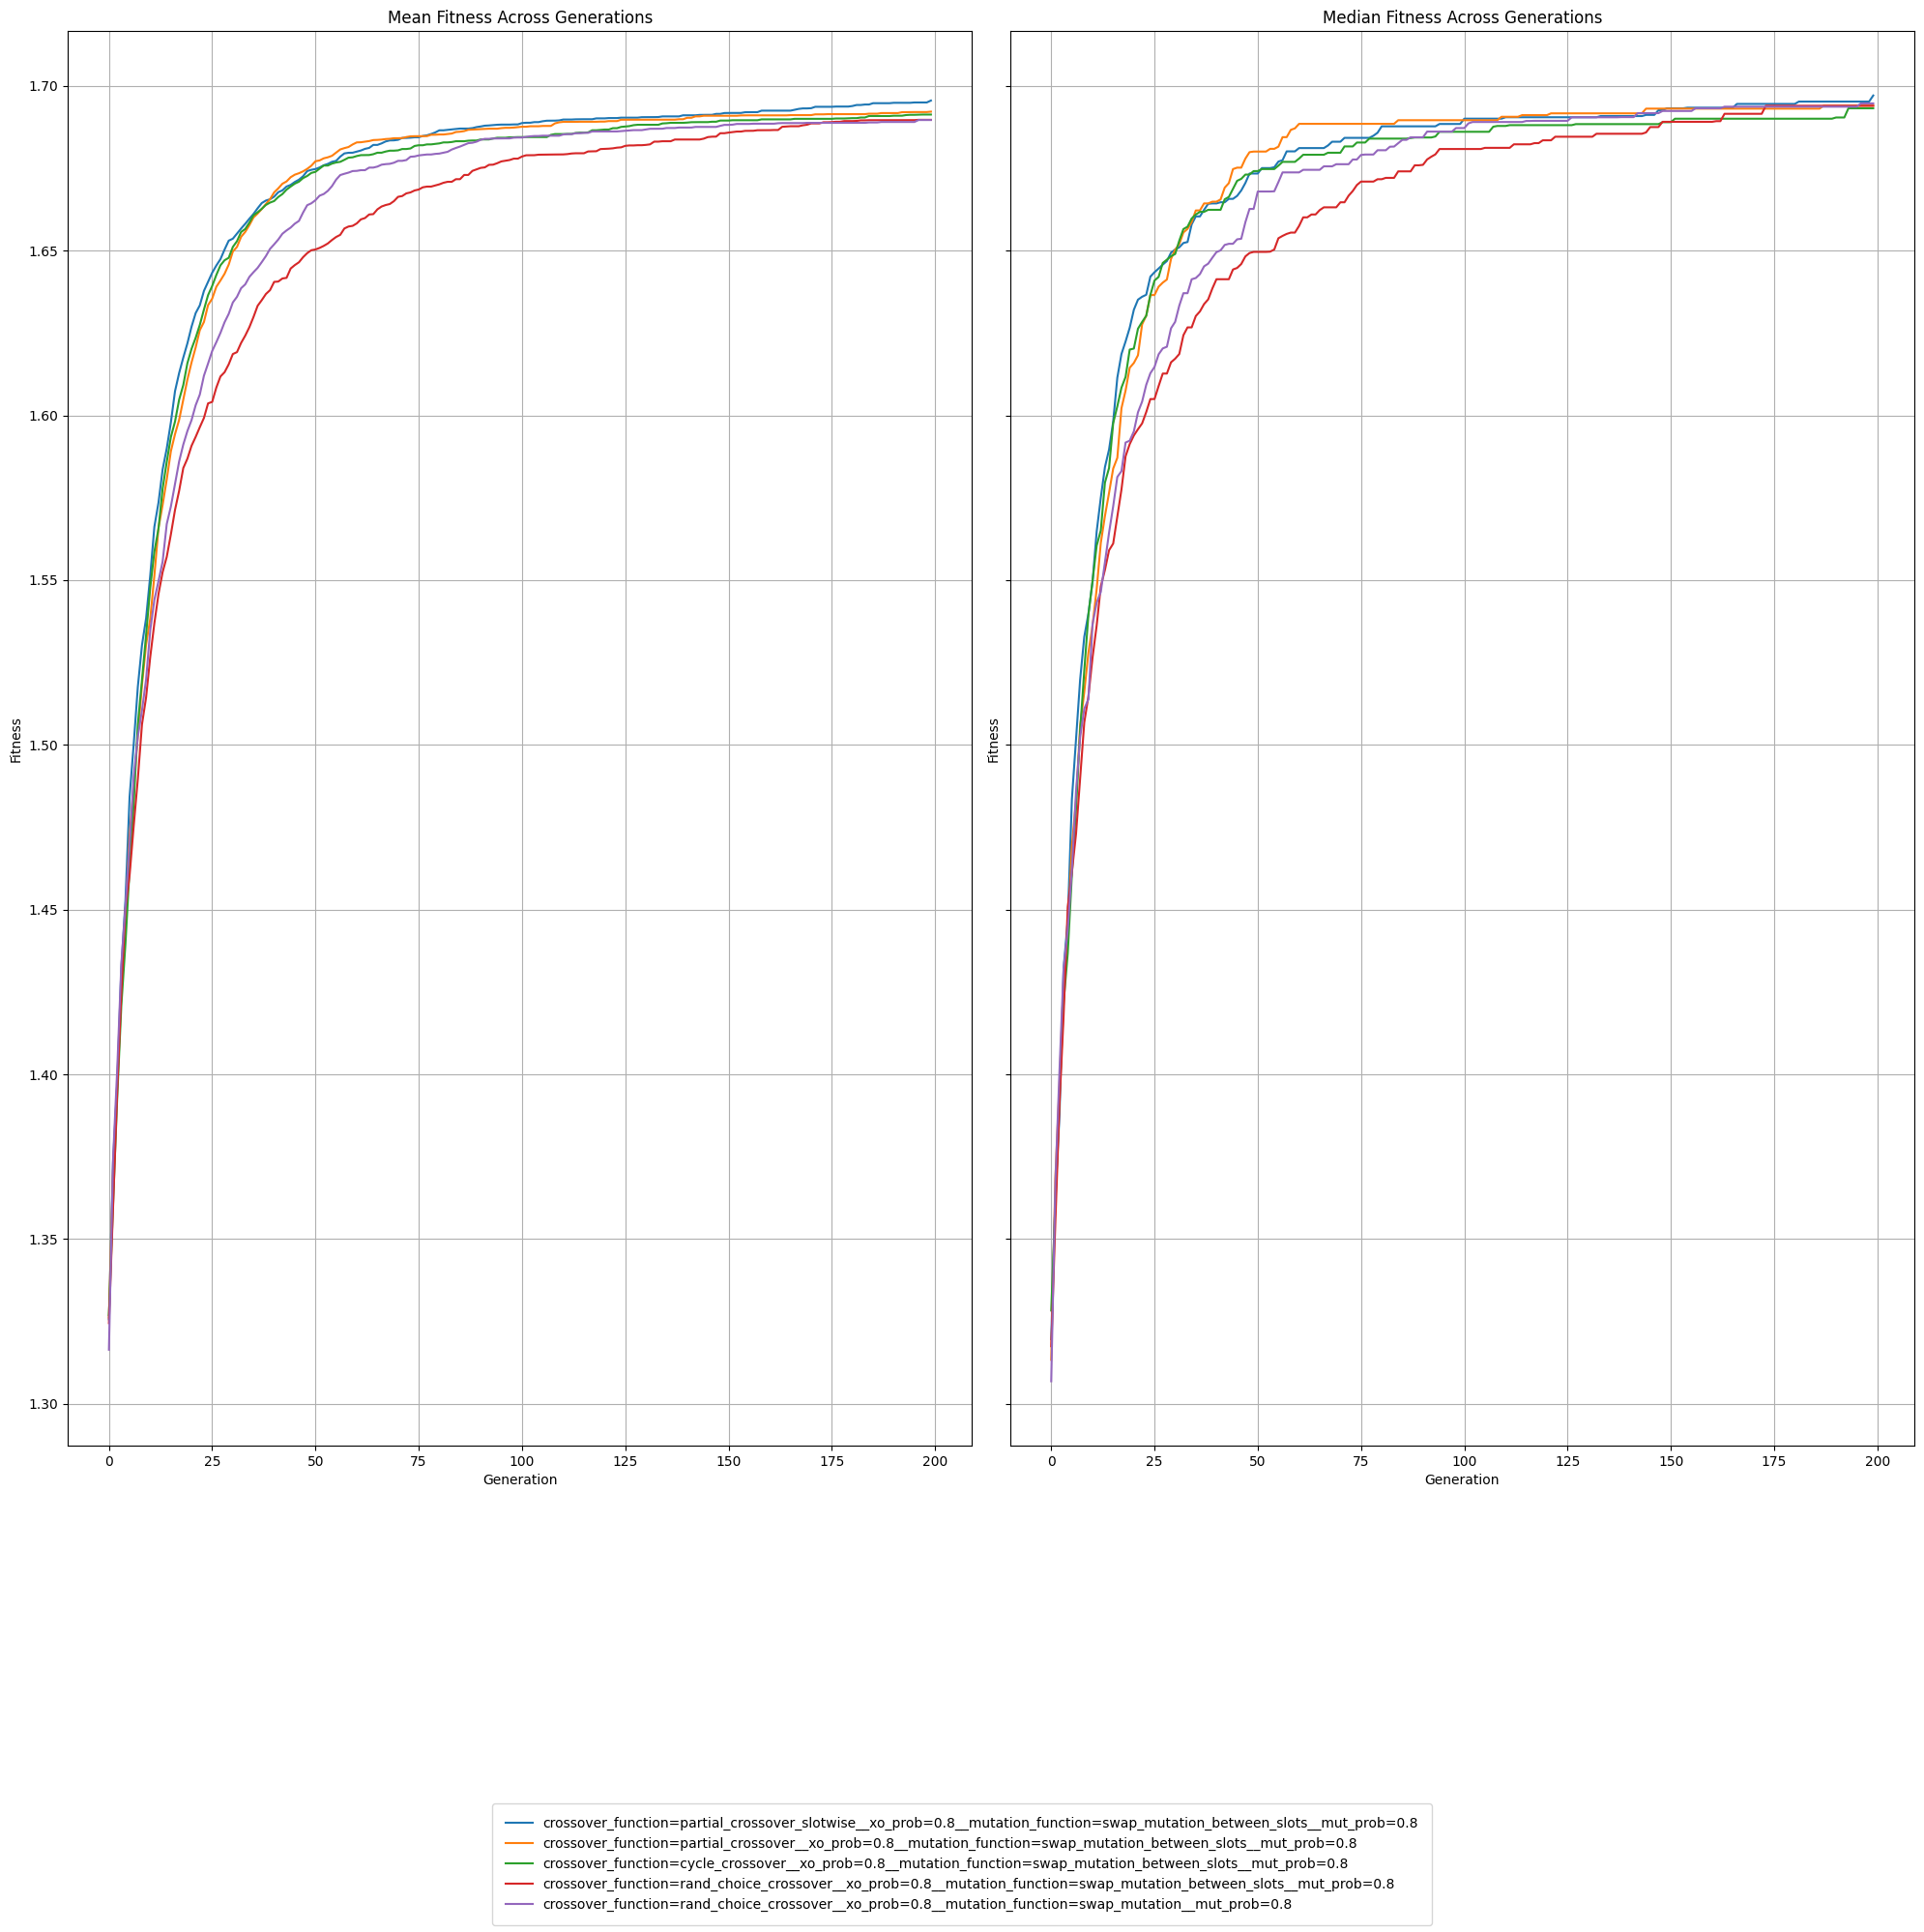

In [326]:
plot_fitness_over_gen_top_n(
    ga_crossover_df_results,top_n=5)

From the plots, both implementations of the partial crossover — the classical and the slot-wise version — performed best overall. 

The two versions show similar performance, though the slot-wise version (blue line) appeared to perform slightly better towards the end.<br>
The cycle crossover (green line) also performed well, but not better than either version of the partial crossover. We will perform statistical tests to determine whether these differences are statistically significant.

Regarding mutation, swap mutation clearly outperformed the others, with the swap_mutation_between_slots variant performing better than the classical version. Notably, the top four configurations all involved slot-based crossovers. We’ll also test whether this difference is significant.
Next, we'll filter the configurations using swap_mutation_between_slots to better compare the performance of the different crossover methods

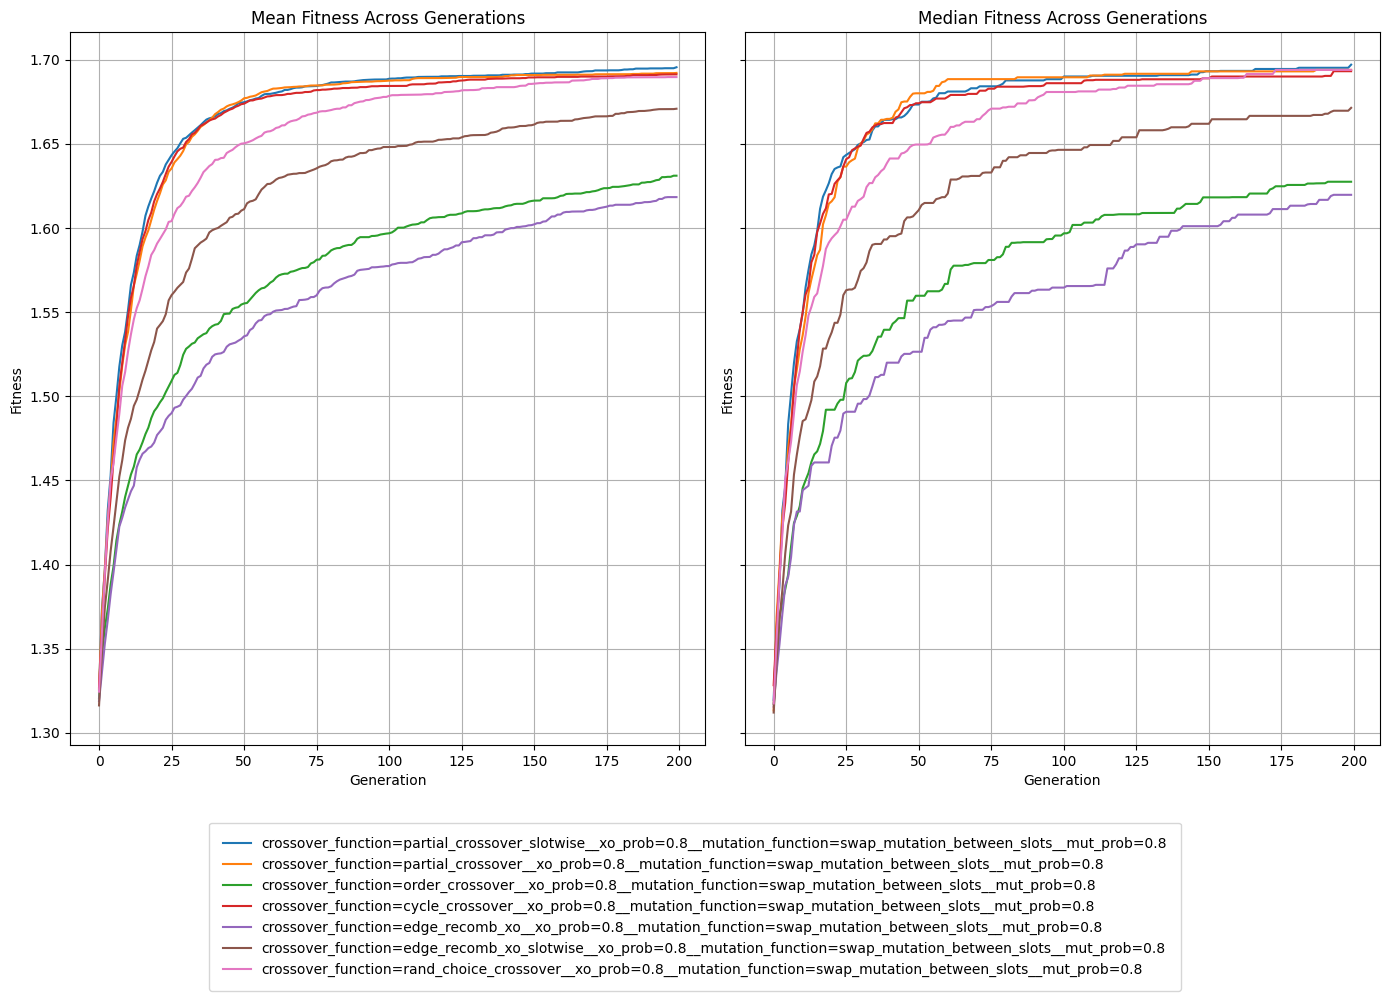

In [328]:
plot_fitness_over_gen(ga_crossover_df_results[ga_crossover_df_results["mutation_function"]=="swap_mutation_between_slots"])

The classical edge recombination crossover had the worst performance overall, while the customized version, edge_recomb_xo_slotwise (brown line), performed significantly better, placing just below rand_choice_crossover.

Rand_choice_crossover showed slow improvement compared to the top crossovers, with slower convergence, but still performed better than the lower-ranking methods.

Order crossover performed the second worst — only slightly better than the classical edge recombination crossover.

The clear top performers are cycle crossover and both versions of partial crossover.
We’ll confirm these differences through statistical tests.

- Overall performance across different crossover methods

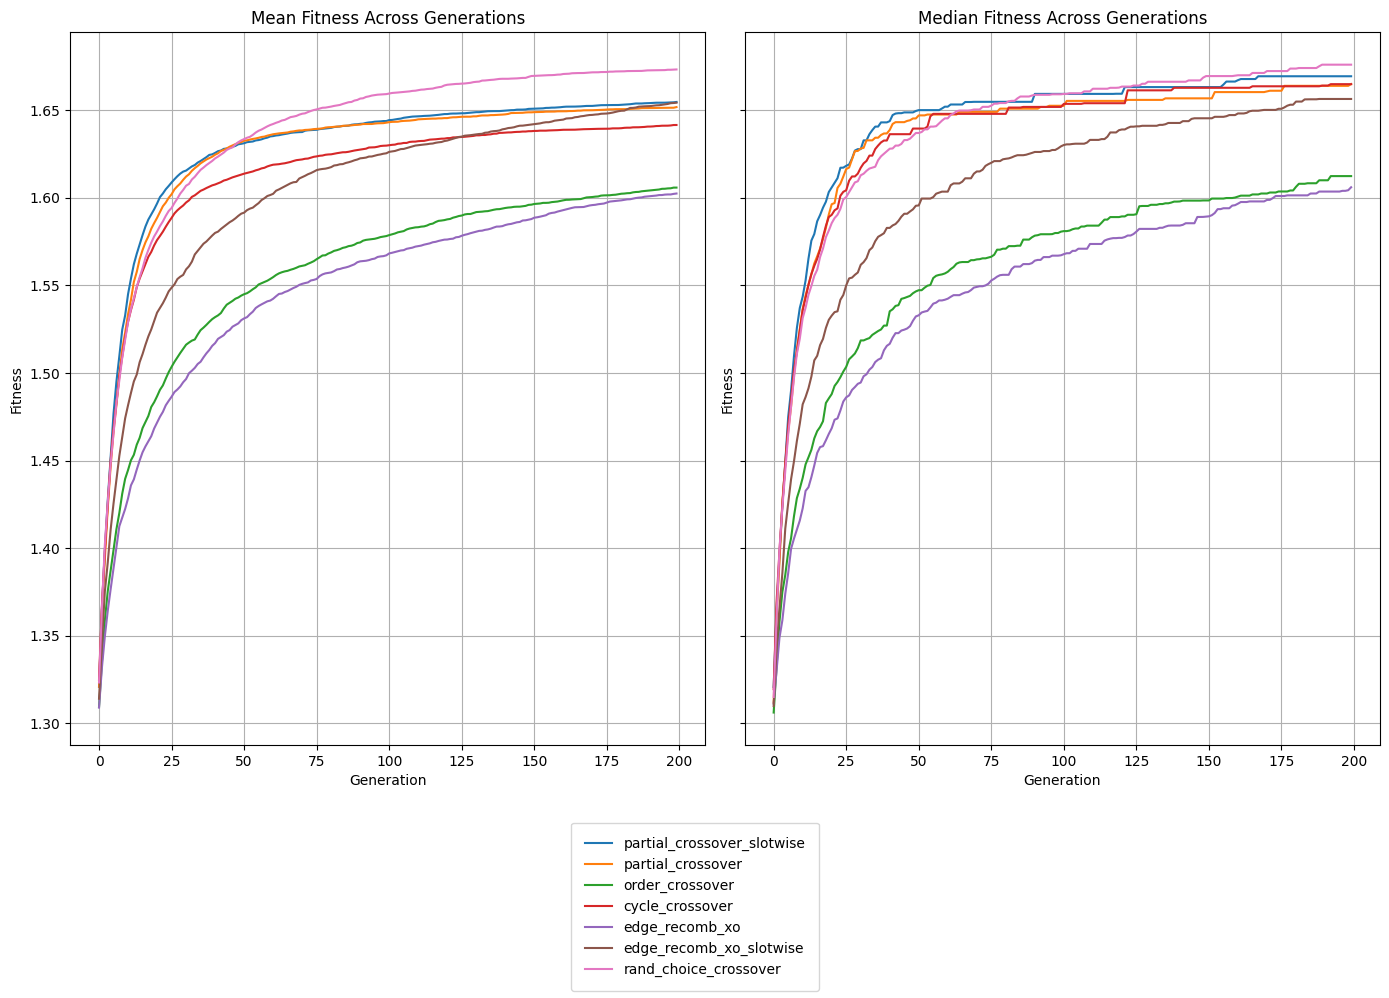

In [330]:
plot_fitness_over_gen(ga_crossover_df_results,param="crossover_function")

Across different mutation methods, rand_choice_crossover tends to perform best overall, though it doesn’t consistently achieve the best fitness values when looking at individual configurations.

- Analysing classival version of Edge recombination crossover and slot wise recombination crossover

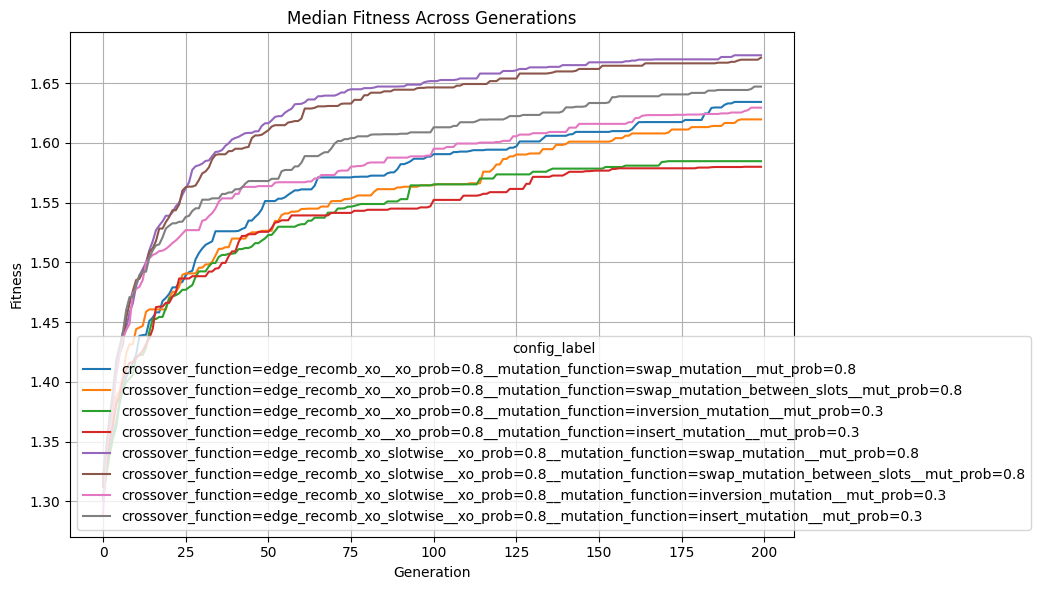

In [333]:
plot_median_fitness_over_gen(
    ga_crossover_df_results[
        ga_crossover_df_results["crossover_function"].isin(
            ["edge_recomb_xo_slotwise","edge_recomb_xo"]
        )
    ]
)

As expected, the slotwise version consistently  better across different mutation functions than the classical version, as  it respects the slot structure  But still, it wasn’t as effective as Partial Crossover or Cycle Crossover.
Next, we should analyse the impact of each crossover and mutation separately, by doing a mean of the runs and a mean of means (for each configuration) across the generations.

In [334]:
def compare_algorithms_wilcoxon(df_1, df_2):
    results = []
    gen_cols = [col for col in df_1.columns if col.isdigit()]

    for gen in gen_cols:
        stat, p_value = wilcoxon(df_1[gen], df_2[gen])
        results.append({'Generation': gen, 'Statistic': stat, 'P-Value': p_value})

    return pd.DataFrame(results)

- #### Analysing crossovers

In [347]:
partial_xo_df=ga_crossover_df_results[ga_crossover_df_results["crossover_function"]=="partial_crossover_slotwise"]
circle_xo_df=ga_crossover_df_results[ga_crossover_df_results["crossover_function"]=="cycle_crossover"]
stats_crossover=compare_algorithms(partial_xo_df,circle_xo_df,alg1_name="partial_crossover", alg2_name="cycle_crossover", alpha=0.05)
stats_crossover.tail()

,Generation,Wilcoxon_statistic,p_value,Median_difference,Better_algorithm
195,195,2091.0,0.000088,0.009370,partial_crossover
196,196,2093.0,0.000090,0.009370,partial_crossover
197,197,2095.0,0.000092,0.009199,partial_crossover
198,198,2099.0,0.000096,0.009199,partial_crossover
199,199,2069.0,0.000069,0.009457,partial_crossover


In [348]:
sig_generations = (stats_crossover['p_value'] < 0.05).sum()
print(f"Significant differences in {sig_generations} out of {len(stats_crossover)} generations")

Significant differences in 195 out of 200 generations


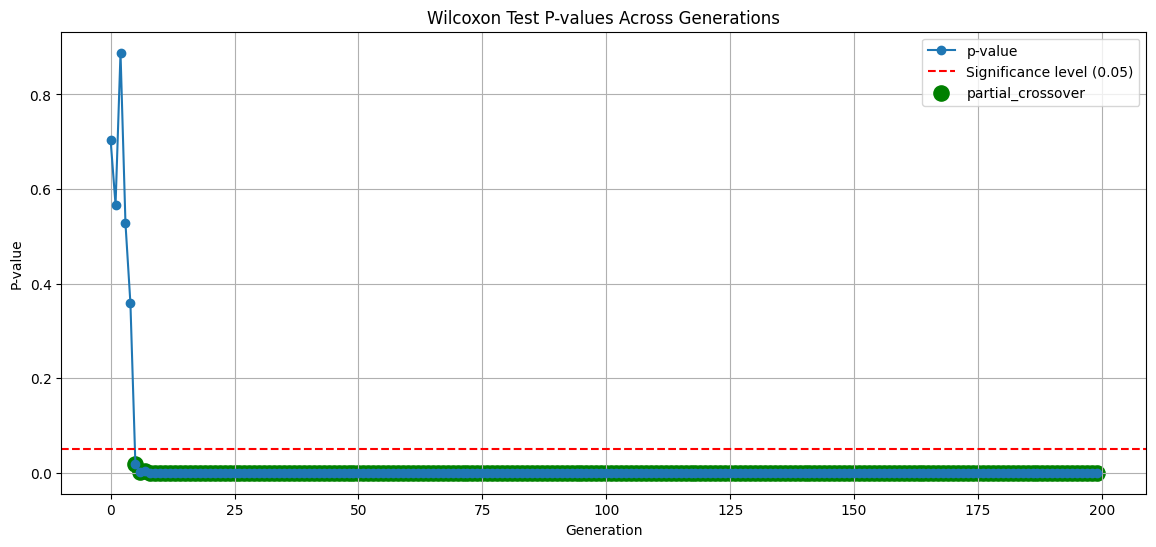

In [349]:
plot_comparison_summary(stats_crossover, alpha=0.05,
                            alg1_name='partial_crossover',
                            alg2_name='cycle_crossover')


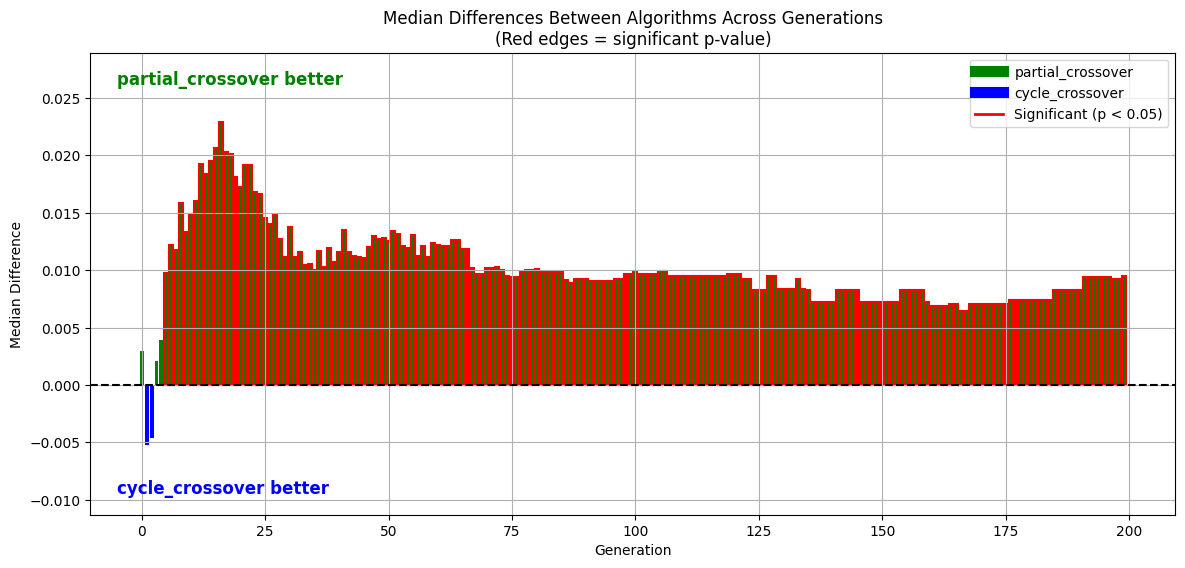

In [350]:
plot_median_difference(stats_crossover,
                            alg1_name='partial_crossover',
                            alg2_name='cycle_crossover')

It is clear that the difference between partial crossover and cycle crossover is statistically significant. 

Across nearly all generations, partial crossover consistently outperformed cycle crossover, suggesting that partial crossover is more effective at preserving and recombining useful building blocks of the solution in this problem context. This result highlights the importance of choosing an appropriate crossover operator, as it directly influences the algorithm’s ability to maintain diversity and guide the search toward high-quality solutions.

Now, let's check if the difference between the two partial crossover methods is statistically significant.

In [345]:
partial_slot_xo_df=ga_crossover_df_results[ga_crossover_df_results["crossover_function"]=="partial_crossover_slotwise"]
partial_classical_xo_df=ga_crossover_df_results[ga_crossover_df_results["crossover_function"]=="partial_crossover"]
stats_crossover_partial=compare_algorithms(partial_slot_xo_df,partial_classical_xo_df,alg1_name="partial_crossover_slotwise", alg2_name="partial_crossover", alpha=0.05)
stats_crossover_partial.head()

,Generation,Wilcoxon_statistic,p_value,Median_difference,Better_algorithm
0,0,3556.0,0.846335,-0.000737,No significant difference
1,1,3610.0,0.958228,-0.002706,No significant difference
2,2,3238.0,0.304610,0.005444,No significant difference
3,3,3235.0,0.300924,0.000245,No significant difference
4,4,3126.0,0.186865,0.005298,No significant difference


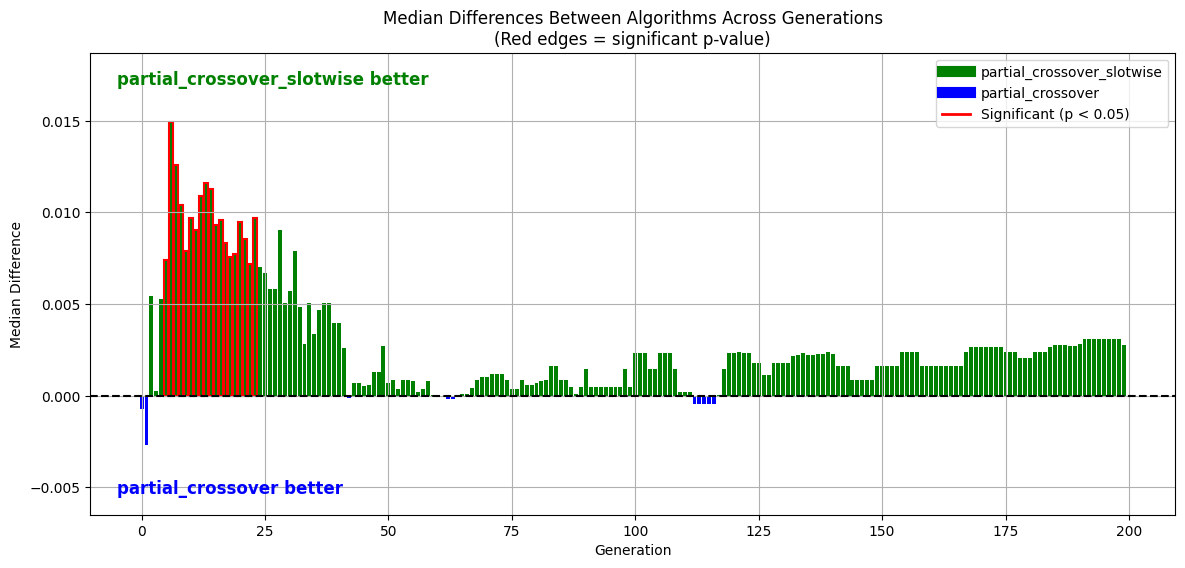

In [351]:
plot_median_difference(stats_crossover_partial,
                            alg1_name='partial_crossover_slotwise',
                            alg2_name='partial_crossover')

The differences favor partial_crossover_slotwise, with some significant differences in the early generations, but for most of the evolution, the differences are not statistically significant.

#### 3.4. Testing the impact of mutation

- Overall performance across different crossover methods


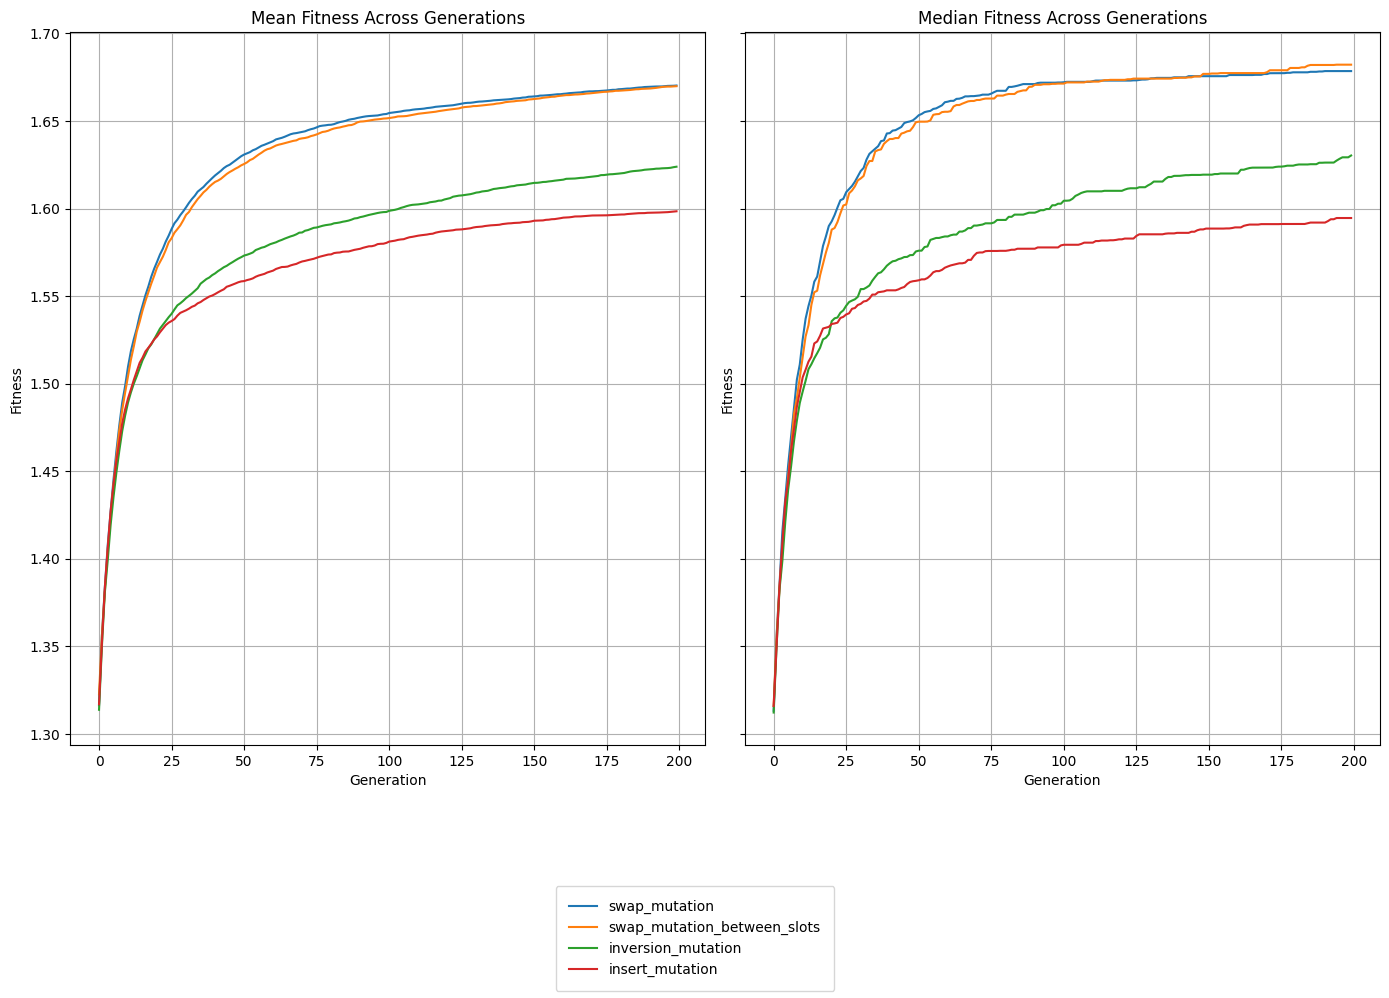

In [352]:
plot_fitness_over_gen(ga_crossover_df_results,param="mutation_function")

Both versions of swap_mutation outperformed all other mutation methods, while insert_mutation showed the weakest performance. We will now conduct statistical tests to confirm these differences.

- Means of means approach

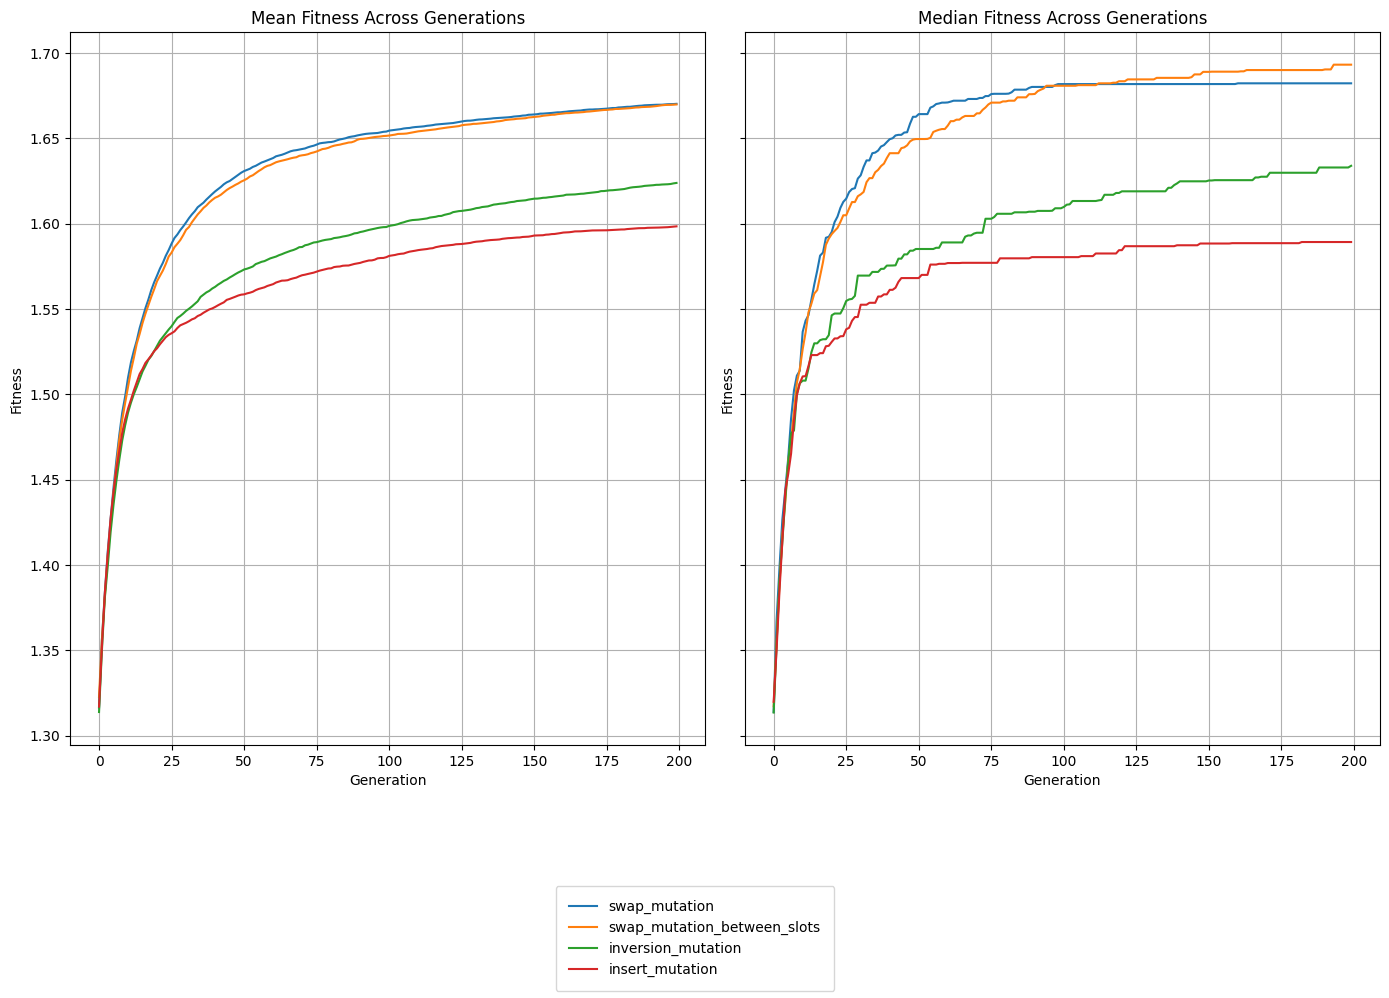

In [388]:
plot_fitness_over_2_gen(ga_crossover_df_results,param="mutation_function")

- Statistical with Wilcoxon Signed-Rank Test

In [304]:
swap_mutation_df=ga_crossover_df_results[ga_crossover_df_results["mutation_function"]=="swap_mutation_between_slots"]
insert_mutation_df=ga_crossover_df_results[ga_crossover_df_results["mutation_function"]=="inversion_mutation"]
stats_mutation=compare_algorithms(swap_mutation_df,insert_mutation_df,alg1_name="swap_mutation_between_slots", alg2_name="inversion_mutation", alpha=0.05)


,Generation,Wilcoxon_statistic,p_value,Median_difference,Better_algorithm
0,0,8012.0,0.000507,0.015559,swap_mutation
1,1,10096.0,0.265589,0.007262,No significant difference
2,2,9086.5,0.023926,0.007539,swap_mutation
3,3,8400.0,0.002390,0.011227,swap_mutation
4,4,8132.5,0.000837,0.010483,swap_mutation


In [355]:
sig_generations = (stats_mutation['p_value'] < 0.05).sum()
print(f"Significant differences in {sig_generations} out of {len(stats_mutation)} generations")

Significant differences in 199 out of 200 generations


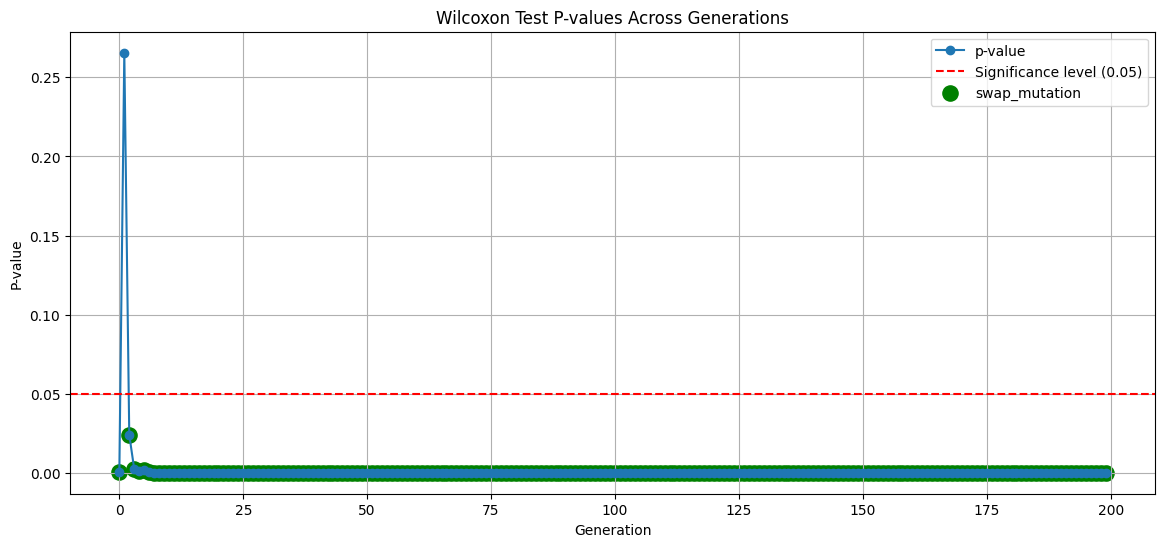

In [356]:
plot_comparison_summary(stats_mutation, alpha=0.05,
                            alg1_name='swap_mutation',
                            alg2_name='inversion_mutation')

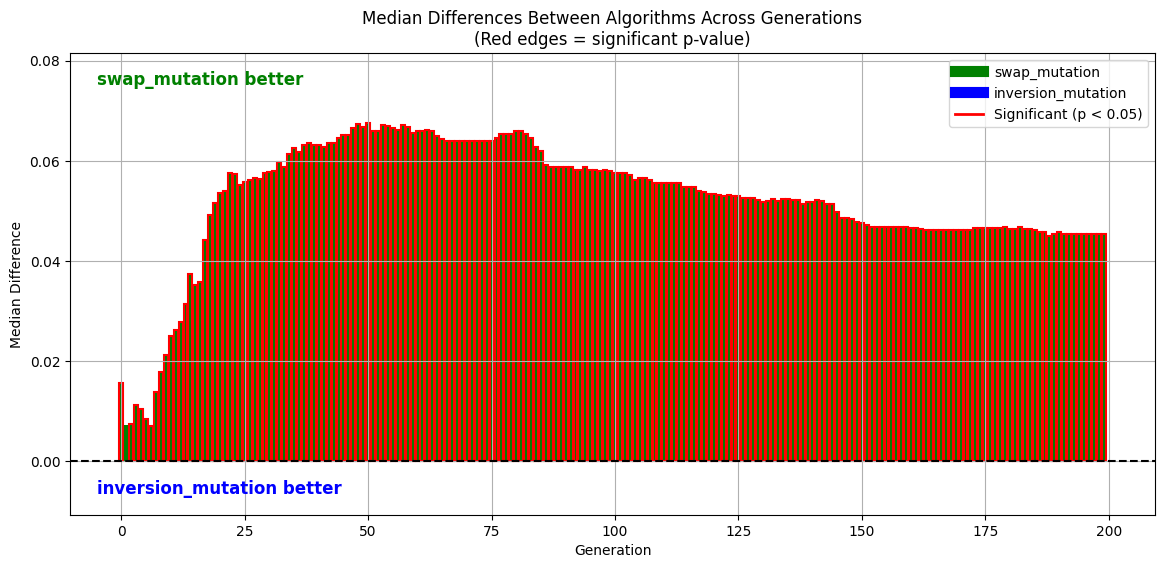

In [357]:
plot_median_difference(stats_mutation,
                            alg1_name='swap_mutation',
                            alg2_name='inversion_mutation')

As expected, swap mutation outperformed the other mutation methods across the generations. This result reinforces its effectiveness in this problem domain, likely due to its ability to produce small yet meaningful changes in the solution structure without disrupting it excessively. The next step is to test whether the difference between its two versions is statistically significant, to determine if one variant offers a measurable advantage over the other.

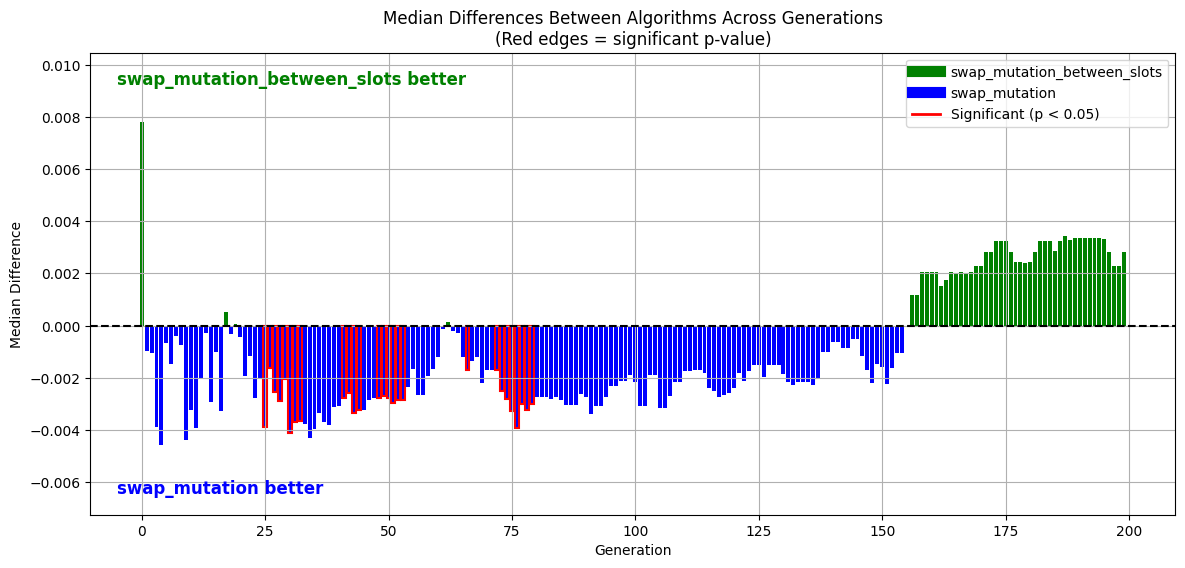

In [358]:
swap_slot_mutation_df=ga_crossover_df_results[ga_crossover_df_results["mutation_function"]=="swap_mutation_between_slots"]
swap_classical_mutation_df=ga_crossover_df_results[ga_crossover_df_results["mutation_function"]=="swap_mutation"]
stats_swap_mutation=compare_algorithms(swap_slot_mutation_df,swap_classical_mutation_df,alg1_name="swap_mutation_between_slots", alg2_name="swap_mutation", alpha=0.05)


plot_median_difference(stats_swap_mutation,
                            alg1_name='swap_mutation_between_slots',
                            alg2_name='swap_mutation')

#### 3.5. Tunning the mut_prob and xo_prob

For this experiment, we focus on understanding how different probabilities for crossover and mutation affect the performance of our genetic algorithm.

We use the Partial Crossover Slotwise operator, which achieved the best performance in previous experiments. To maintain a balanced selection pressure, we set the selection method to Tournament Selection with size 5. The mutation operator chosen is Swap Mutation, as it consistently outperformed other mutation strategies.

The population size and number of generations remain fixed at 100 and 200, respectively, to ensure a fair comparison across probability settings

In [359]:
param_grid = {
   "mut_prob": [ 0.7, 0.8, 0.9]   ,     
    "xo_prob": [0.8,0.9,1.0]
       
}

fixed_params = {
    "pop_size": 100,
    "max_gen": 200,
    "data": data , 
    "elitism":True,
    "crossover_function": partial_crossover_slotwise,
    "selection_algorithm": tournament_selection_7,
    "mutation_function":swap_mutation_between_slots
}

In [360]:
ga_prob_df_results= run_algorithms_grid_search(
    algorithm_func=run_GA,
    param_grid=param_grid,
    fixed_params=fixed_params,
    runs_per_config=30,
    output_csv_path="ga_grid_prob_tuning_custom_results.csv"
)

Running config: mut_prob=0.7__xo_prob=0.8
Running config: mut_prob=0.7__xo_prob=0.9
Running config: mut_prob=0.7__xo_prob=1.0
Running config: mut_prob=0.8__xo_prob=0.8
Running config: mut_prob=0.8__xo_prob=0.9
Running config: mut_prob=0.8__xo_prob=1.0
Running config: mut_prob=0.9__xo_prob=0.8
Running config: mut_prob=0.9__xo_prob=0.9
Running config: mut_prob=0.9__xo_prob=1.0
Saved results to ga_grid_prob_tuning_custom_results.csv


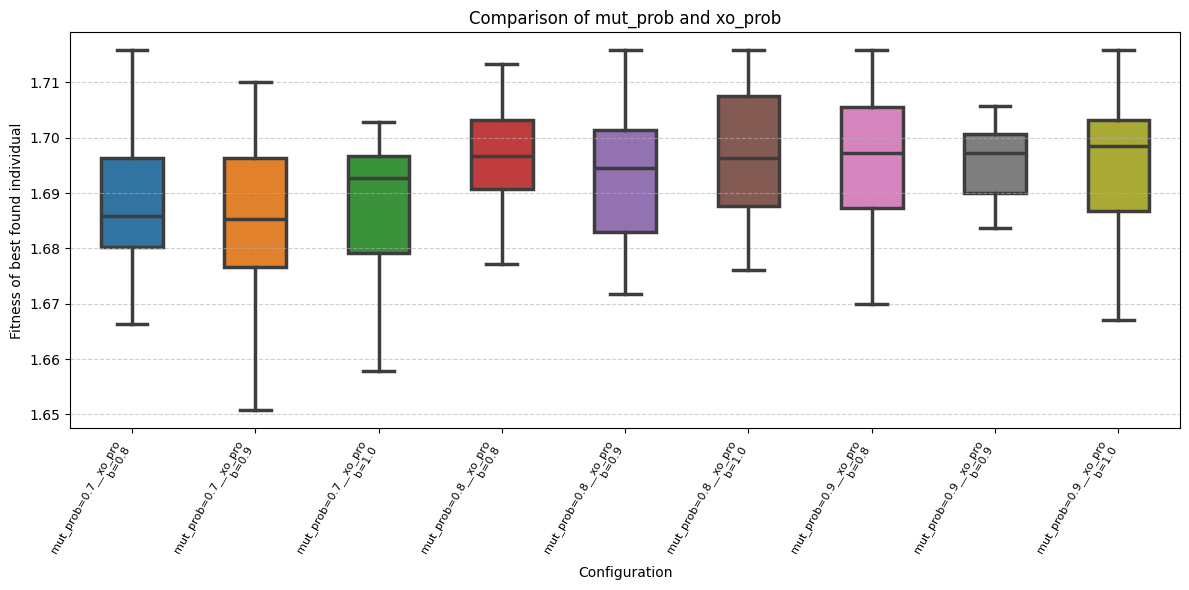

In [361]:
plt.figure(figsize=(12, 6))

# Create boxplot
ax = sns.boxplot(x='config_label', y='best_fitness', data=ga_prob_df_results, 
                 width=0.5, linewidth=2.5, fliersize=0)

plt.title('Comparison of mut_prob and xo_prob')
plt.xlabel('Configuration')
plt.ylabel('Fitness of best found individual')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

# Replace 'neighbor_function', wrap, and rotate labels with smaller font
labels = [
    textwrap.fill(label.get_text(), 20)
    for label in ax.get_xticklabels()
]
ax.set_xticklabels(labels, rotation=60, ha='right', fontsize=8)  # Adjust fontsize here

plt.tight_layout()
plt.show()

The experimental results show only subtle differences in performance across the various combinations of crossover and mutation probabilities. Fitness values consistently range between 1.67 and 1.71, indicating that all configurations yield solutions of comparable quality. For the remainder of this study, we will use a crossover probability of 0.8 and a mutation probability of 0.8, as this configuration demonstrates a slightly higher median performance and appears to produce the best results.

### 4. Comparing the Simulated Annealing and Genetic Algorithm Performance

In this final experiment, we compare the performance of Simulated Annealing (SA) and the Genetic Algorithm (GA) on the same problem instance, using a similar mutation strategy. <br>

- **For SA**, we used swap_mutation_between_slots as the neighbor function, C=200, L=10, H=1.1, and 1000 iterations. (the best from earlier tests).<br>

- **For GA**, the setup included a population of 100 over 100 generations, tournament selection with size 7, and the partial_crossover_slotwise crossover (the best from earlier tests),  Crossover probability 0.8 and mutation used swap_mutation_between_slots with a high probability of 0.8.

<br>
To compare both algorithms fairly, we will evaluate their performance at equivalent points based on the number of fitness evaluations performed, since this is the main computational cost in both methods. 
<br>
Since we are using elitism, for the Genetic Algorithm, the total number of evaluations up to a certain generation is given by multiplying the population size by the number of generations (pop_size * generation). In the case of Simulated Annealing, the number of evaluations is calculated by multiplying L by the number of iterations performed (L * iteration). This allows us to plot and compare the convergence of both algorithms based on the same computational effort.


In [422]:
overall_results_SA=[]
overall_results_GA=[]
for i in range(30):
    L=10
    pop_size=100
    best_SA,fitness_over_iter_SA=run_SA(data=data,neighbor_function=swap_mutation_between_slots,C=200, L=L, H=1.1,max_iter=1000)
    best_GA,fitness_over_iter_GA=run_GA(data,
                    pop_size=pop_size,
                    max_gen=100,
                    selection_algorithm=tournament_selection_7,
                    crossover_function=partial_crossover_slotwise,
                    mutation_function=swap_mutation_between_slots,
                    mut_prob=0.8,
                    xo_prob=0.8
                    )
    row_SA={"run_id":i, "model":"SA", "fitness":best_SA.fitness()}
    row_GA={"run_id":i, "model":"GA", "fitness":best_GA.fitness()}
    for gen_idx, fitness in enumerate(fitness_over_iter_SA):
        row_SA[f"{(gen_idx+1)*L}"] = fitness
    for gen_idx, fitness in enumerate(fitness_over_iter_GA):
        row_GA[f"{(gen_idx+1)*pop_size}"]=fitness
    overall_results_SA.append(row_SA)
    overall_results_GA.append(row_GA)
overall_results_SA_df=pd.DataFrame(overall_results_SA)
overall_results_GA_df=pd.DataFrame(overall_results_GA)


In [423]:
overall_results_SA_df.head()

,run_id,model,fitness,10,20,30,40,50,60,70,...,9910,9920,9930,9940,9950,9960,9970,9980,9990,10000
0,0,SA,1.687802,1.153383,1.121560,0.960736,0.918767,0.850113,0.903364,1.204844,...,1.687802,1.687802,1.687802,1.687802,1.687802,1.687802,1.687802,1.687802,1.687802,1.687802
1,1,SA,1.693059,0.821111,0.944165,0.817315,0.785571,0.944513,0.899738,1.051139,...,1.693059,1.693059,1.693059,1.693059,1.693059,1.693059,1.693059,1.693059,1.693059,1.693059
2,2,SA,1.679972,1.068364,1.004252,1.020791,1.100979,1.183979,0.997069,1.095301,...,1.679972,1.679972,1.679972,1.679972,1.679972,1.679972,1.679972,1.679972,1.679972,1.679972
3,3,SA,1.704231,1.007966,0.988712,1.075906,1.010054,0.943684,1.019134,0.855864,...,1.704231,1.704231,1.704231,1.704231,1.704231,1.704231,1.704231,1.704231,1.704231,1.704231
4,4,SA,1.676744,0.973369,1.055732,0.841372,0.972911,1.007733,1.126043,1.045562,...,1.676744,1.676744,1.676744,1.676744,1.676744,1.676744,1.676744,1.676744,1.676744,1.676744


overall_results=[]
for i in range(30):
    best_HC=run_HC(data)
    best_SA,_=run_SA(data=data,neighbor_function=swap_mutation,C=100, L=9, H=1.2,max_iter=1000)
    best_GA,_=run_GA(data,
                    pop_size=50,
                    max_gen=20,
                    selection_algorithm=fitness_proportionate_selection,
                    crossover_function=cycle_crossover,
                    mutation_function=swap_mutation
                    )
    overall_results.append({"run_id":i, "model":"HC", "fitness":best_HC.fitness()})
    overall_results.append({"run_id":i, "model":"SA", "fitness":best_SA.fitness()})
    overall_results.append({"run_id":i, "model":"GA", "fitness":best_GA.fitness()})
overall_results_df=pd.DataFrame(overall_results)
overall_results_df.to_csv("overall_results.csv")

In [424]:
overall_results_GA_df.head()

,run_id,model,fitness,100,200,300,400,500,600,700,...,9100,9200,9300,9400,9500,9600,9700,9800,9900,10000
0,0,GA,1.688429,1.373489,1.384917,1.427775,1.428489,1.440632,1.461602,1.480888,...,1.688429,1.688429,1.688429,1.688429,1.688429,1.688429,1.688429,1.688429,1.688429,1.688429
1,1,GA,1.693773,1.306955,1.358237,1.364002,1.413466,1.439180,1.446346,1.497518,...,1.693773,1.693773,1.693773,1.693773,1.693773,1.693773,1.693773,1.693773,1.693773,1.693773
2,2,GA,1.699231,1.295632,1.344203,1.442573,1.449203,1.489002,1.501145,1.520430,...,1.699231,1.699231,1.699231,1.699231,1.699231,1.699231,1.699231,1.699231,1.699231,1.699231
3,3,GA,1.683974,1.250640,1.337898,1.337898,1.388782,1.391639,1.456689,1.488118,...,1.679688,1.679688,1.683974,1.683974,1.683974,1.683974,1.683974,1.683974,1.683974,1.683974
4,4,GA,1.679373,1.332211,1.390297,1.411726,1.438868,1.465577,1.493154,1.493154,...,1.678402,1.678402,1.678402,1.678402,1.678402,1.679373,1.679373,1.679373,1.679373,1.679373


- Get the intersection of the two

In [425]:
results_GA_SA=concat_with_intersection(overall_results_SA_df,overall_results_GA_df)
results_GA_SA["model"].value_counts()

model
SA    30
GA    30
Name: count, dtype: int64

In [426]:
results_GA_SA.head()

,5400,100,400,5800,9400,1800,5200,10000,1400,6200,...,9200,2500,8800,2100,3200,4700,8300,3800,6000,model
0,1.687802,1.182554,1.140892,1.687802,1.687802,1.655659,1.687802,1.687802,1.578232,1.687802,...,1.687802,1.687802,1.687802,1.672088,1.687802,1.687802,1.687802,1.687802,1.687802,SA
1,1.693059,1.173008,0.845745,1.693059,1.693059,1.659002,1.693059,1.693059,1.616744,1.693059,...,1.693059,1.688287,1.693059,1.677573,1.693059,1.693059,1.693059,1.693059,1.693059,SA
2,1.679972,0.947559,0.947476,1.679972,1.679972,1.643544,1.679972,1.679972,1.621401,1.679972,...,1.679972,1.669972,1.679972,1.664258,1.679972,1.679972,1.679972,1.679972,1.679972,SA
3,1.704231,0.975136,0.960965,1.704231,1.704231,1.643059,1.704231,1.704231,1.635774,1.704231,...,1.704231,1.704231,1.704231,1.691145,1.704231,1.704231,1.704231,1.704231,1.704231,SA
4,1.676744,0.898415,0.765374,1.676744,1.676744,1.672459,1.676744,1.676744,1.605861,1.676744,...,1.676744,1.676744,1.676744,1.676744,1.676744,1.676744,1.676744,1.676744,1.676744,SA


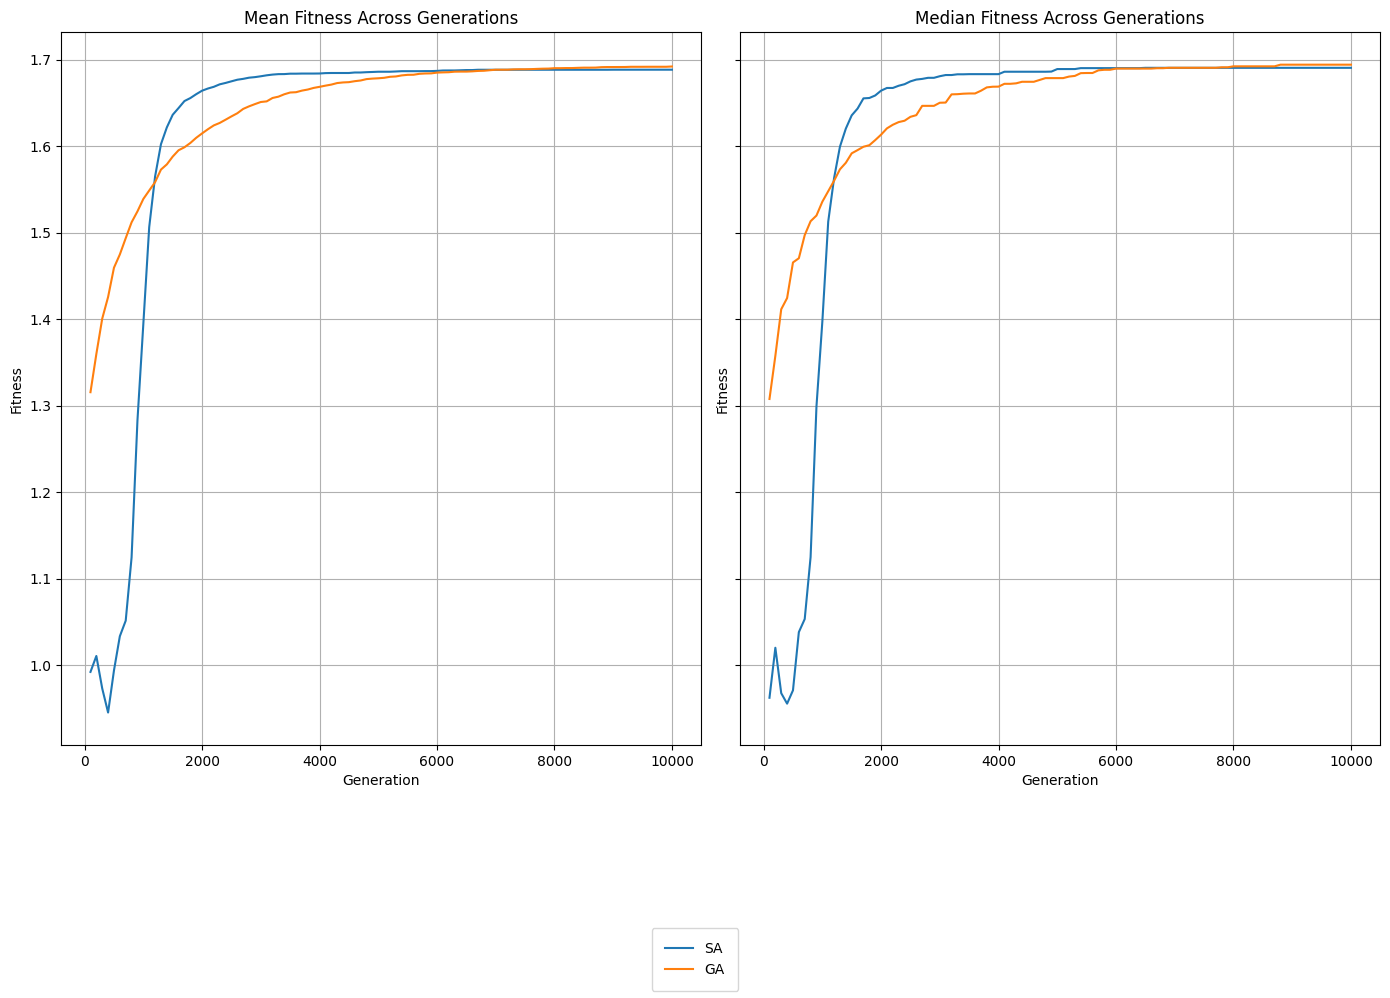

In [427]:
plot_fitness_over_gen(results_GA_SA, param="model")

In [428]:
ga_df=results_GA_SA[results_GA_SA["model"]=="GA"]
sa_df=results_GA_SA[results_GA_SA["model"]=="SA"]
stats_ga_sa=compare_algorithms(ga_df,sa_df,alg1_name="GA", alg2_name="SA", alpha=0.05)
stats_ga_sa.head()

,Generation,Wilcoxon_statistic,p_value,Median_difference,Better_algorithm
0,5400,185.0,3.387418e-01,0.000043,No significant difference
1,100,0.0,1.862645e-09,0.341951,GA
2,400,0.0,1.862645e-09,0.484383,GA
3,5800,212.0,6.850471e-01,0.003871,No significant difference
4,9400,172.5,2.285528e-01,0.006914,No significant difference


In [429]:
sig_generations = (stats_ga_sa['p_value'] < 0.05).sum()
print(f"Significant differences in {sig_generations} out of {len(stats_mutation)} generations")

Significant differences in 47 out of 200 generations


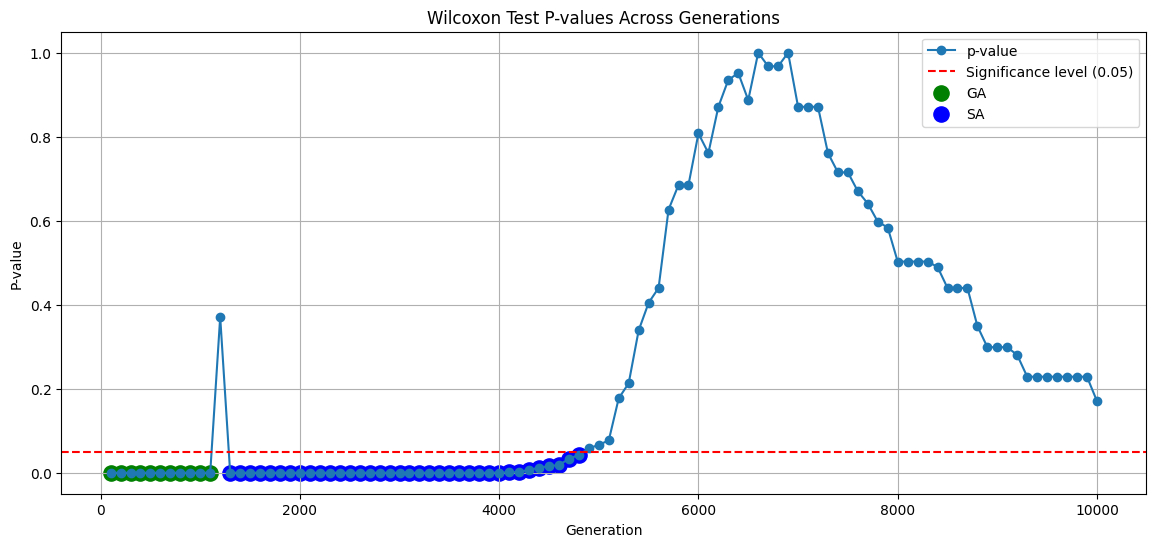

In [430]:
plot_comparison_summary(stats_ga_sa, alpha=0.05,
                            alg1_name='GA',
                            alg2_name='SA')

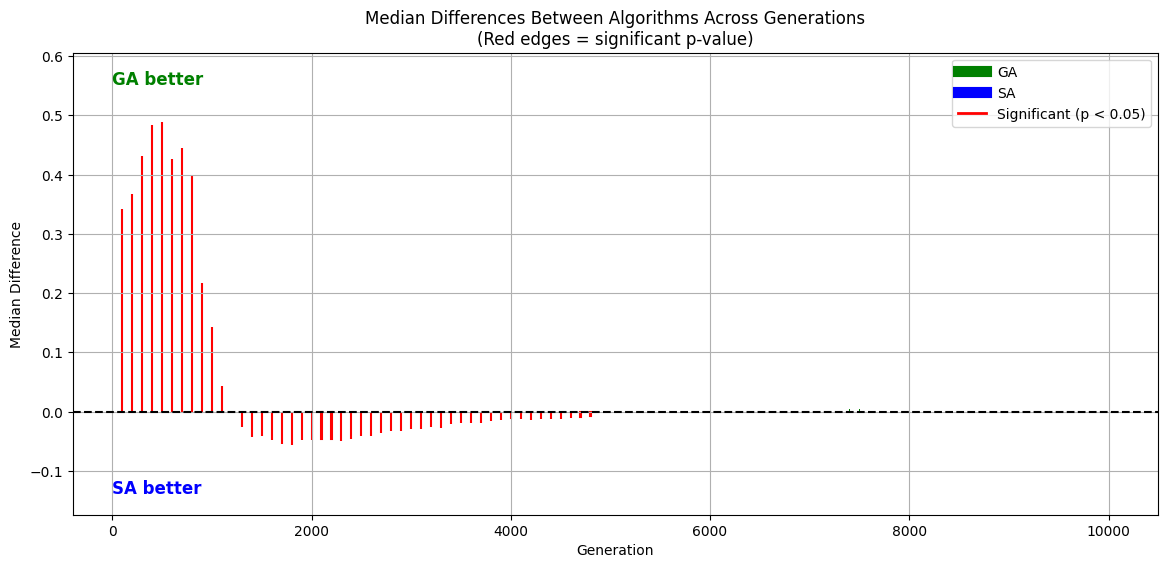

In [432]:
plot_median_difference(stats_ga_sa,
                            alg1_name='GA',
                            alg2_name='SA')

- Best fitness found

In [383]:
best_row = ga_crossover_df_results.loc[ga_crossover_df_results['best_fitness'].idxmax()]
best_fitness_df=visualize_musical_lineup(best_row["best_solution"],data.artists_df)
best_fitness_df

,Slot,Stage 1,Stage 2,Stage 3,Stage 4,Stage 5
0,Slot 1,24: Shadow Cadence|Jazz|66,5: Echo Chamber|Electronic|98,16: Mystic Rhythms|Classical|78,27: Hypnotic Echoes|Rock|77,26: Cloud Nine Collective|Pop|97
1,Slot 2,12: Blue Horizon|Pop|51,9: Deep Resonance|Jazz|90,21: Celestial Voyage|Electronic|95,4: The Silver Owls|Classical|85,18: Velvet Underground|Rock|72
2,Slot 3,20: The Sonic Drifters|Rock|88,28: The Polyrhythm Syndicate|Jazz|66,33: Cosmic Frequency|Rock|53,6: Aurora Skies|Pop|75,34: Parallel Dimension|Electronic|58
3,Slot 4,0: Midnight Echo|Rock|75,11: Phantom Groove|Hip-Hop|47,1: Solar Flare|Electronic|78,2: Velvet Pulse|Jazz|35,8: Crimson Harmony|Classical|20
4,Slot 5,31: The Jazz Nomads|Jazz|64,15: Golden Ember|Rock|61,19: Astral Tide|Electronic|69,29: Harmonic Dissonance|Classical|96,7: Static Mirage|Rock|94
5,Slot 6,23: Electric Serpents|Electronic|99,10: The Wandering Notes|Jazz|84,17: Nightfall Sonata|Classical|84,32: The Bassline Architects|Hip-Hop|61,30: Turbo Vortex|Rock|53
6,Slot 7,13: Lunar Spectrum|Rock|99,14: Synthwave Saints|Rock|94,22: Quantum Beat|Hip-Hop|96,25: Rhythm Alchemy|Jazz|94,3: Neon Reverie|Electronic|100
